#  Model Comparison — Rossmann Store Sales

### Plan
1. Load data & all saved models
2. MAE / RMSE / MAPE comparison table
3. Actual vs Predicted plots (all models)
4. Error distribution comparison
5. Per-store error analysis
6. XGBoost error by day & month
7. Final summary

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pickle
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'figure.figsize': (14, 5), 'axes.titlesize': 13})

STORE_ID = 1
print('Imports done ✅')

Imports done ✅


## 2. Load Data & Models

In [2]:
val_df = pd.read_csv('../data/processed/val_featured.csv', parse_dates=['Date'])

feature_cols = pd.read_csv('../data/processed/feature_list.csv')['feature'].tolist()
feature_cols = [f for f in feature_cols if f in val_df.columns]

X_val        = val_df[feature_cols].fillna(0)
y_val_actual = np.expm1(val_df['Sales_log'].values)

print(f'Val samples : {len(val_df):,}')
print(f'Features    : {len(feature_cols)}')

Val samples : 168,380
Features    : 94


In [3]:
with open('../models/random_forest.pkl', 'rb') as f:
    rf_model = pickle.load(f)

with open('../models/xgboost.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

with open('../models/arima_model.pkl', 'rb') as f:
    arima_model = pickle.load(f)

print('All models loaded ✅')

All models loaded ✅


In [5]:
# ML predictions — all stores
rf_pred  = np.expm1(rf_model.predict(X_val))
xgb_pred = np.expm1(xgb_model.predict(X_val))

# ARIMA predictions — Store 1 only
store_mask   = (val_df['Store'] == STORE_ID).values
n_arima      = int(store_mask.sum())
arima_pred   = np.expm1(arima_model.predict(n_periods=n_arima))
arima_actual = y_val_actual[store_mask]

print(f'RF / XGB predictions : {len(rf_pred):,}')
print(f'ARIMA predictions    : {len(arima_pred)} (Store {STORE_ID})')

RF / XGB predictions : 168,380
ARIMA predictions    : 150 (Store 1)


c:\Users\rajni\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 3. Evaluation — MAE, RMSE, MAPE

In [6]:
def evaluate(actual, predicted, label):
    mae  = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-8))) * 100
    return {'Model': label, 'MAE': round(mae, 2), 'RMSE': round(rmse, 2), 'MAPE%': round(mape, 2)}

results = [
    evaluate(y_val_actual, rf_pred,    'Random Forest'),
    evaluate(y_val_actual, xgb_pred,   'XGBoost'),
    evaluate(arima_actual, arima_pred, f'ARIMA(2,1,2)  [Store {STORE_ID}]'),
]

results_df = pd.DataFrame(results)
print('\n=== Model Comparison ===')
print(results_df.to_string(index=False))


=== Model Comparison ===
                  Model    MAE    RMSE  MAPE%
          Random Forest 748.71 1115.93  10.91
                XGBoost 647.59  942.15   9.33
ARIMA(2,1,2)  [Store 1] 720.30  868.89  16.82


## 4. MAE & RMSE Bar Chart

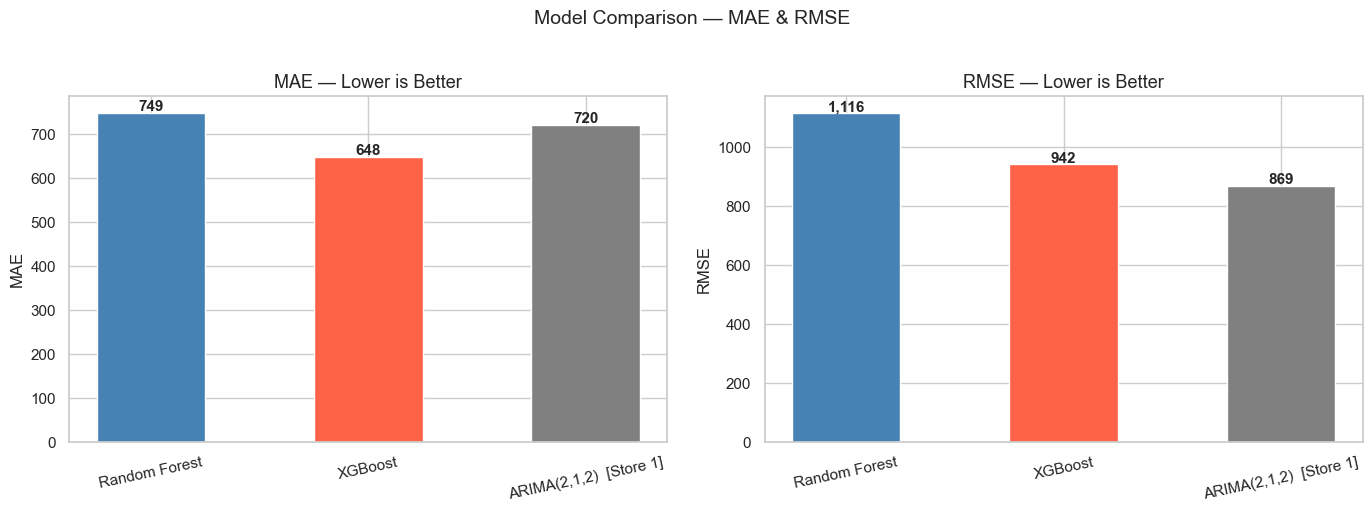

In [7]:
colors = ['steelblue', 'tomato', 'gray']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric in zip(axes, ['MAE', 'RMSE']):
    bars = ax.bar(results_df['Model'], results_df[metric],
                  color=colors, edgecolor='white', width=0.5)
    ax.set_title(f'{metric} — Lower is Better')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=12)
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 5,
                f'{val:,.0f}', ha='center', fontweight='bold', fontsize=11)

plt.suptitle('Model Comparison — MAE & RMSE', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/final_comparison.png', dpi=150)
plt.show()

## 5. Actual vs Predicted — Store 1 (All Models)

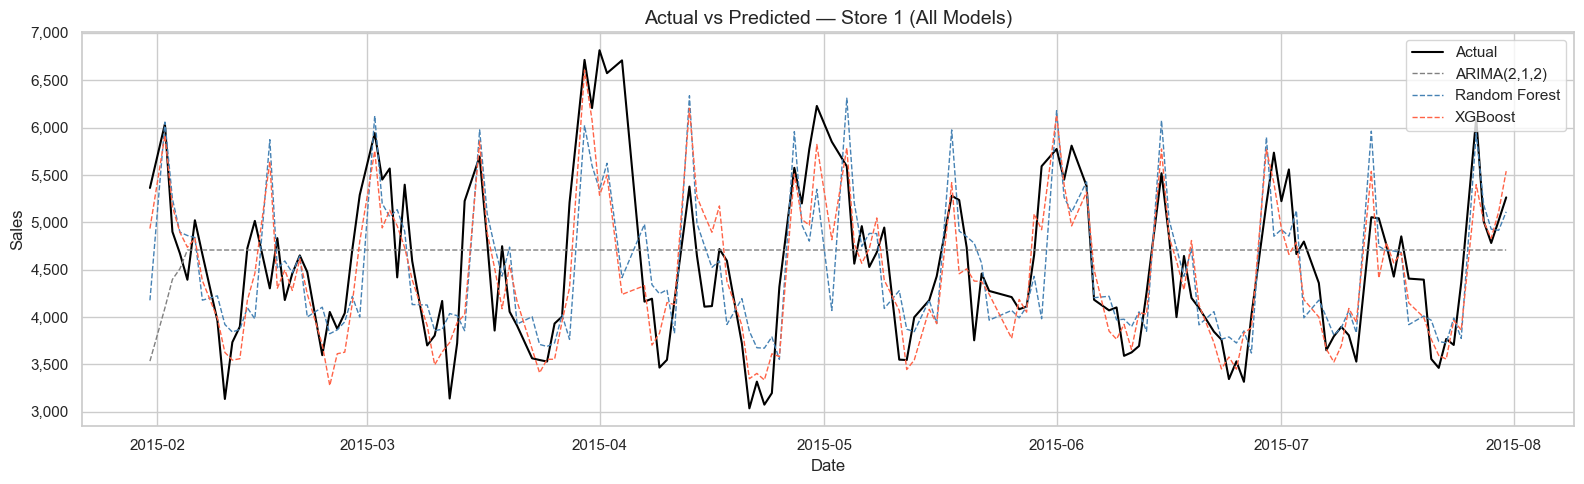

In [8]:
dates_s    = val_df.loc[store_mask, 'Date'].values
rf_pred_s  = rf_pred[store_mask]
xgb_pred_s = xgb_pred[store_mask]

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(dates_s, arima_actual, color='black',     linewidth=1.5, label='Actual')
ax.plot(dates_s, arima_pred,   color='gray',      linewidth=1.0, linestyle='--', label='ARIMA(2,1,2)')
ax.plot(dates_s, rf_pred_s,    color='steelblue', linewidth=1.0, linestyle='--', label='Random Forest')
ax.plot(dates_s, xgb_pred_s,   color='tomato',    linewidth=1.0, linestyle='--', label='XGBoost')

ax.set_title(f'Actual vs Predicted — Store {STORE_ID} (All Models)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/all_models_forecast.png', dpi=150)
plt.show()

## 6. Error Distribution Comparison

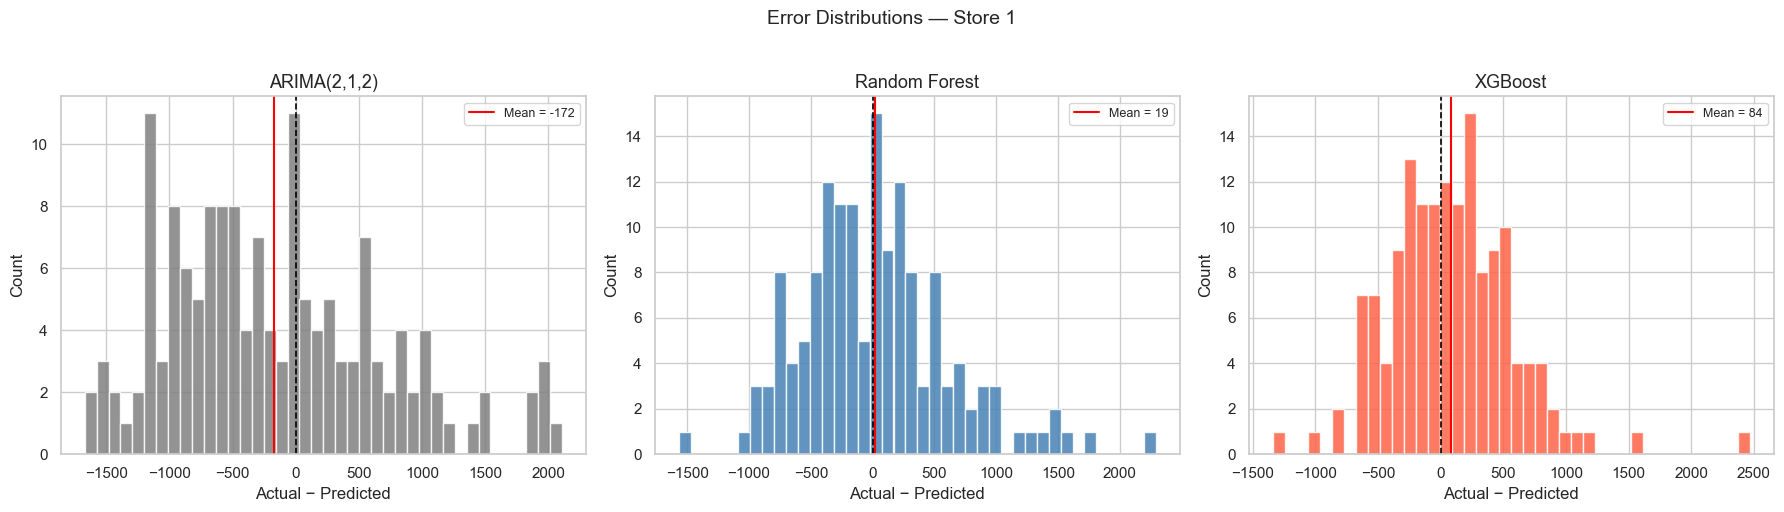

In [9]:
errors = {
    'ARIMA(2,1,2)' : arima_actual - arima_pred,
    'Random Forest': arima_actual - rf_pred_s,
    'XGBoost'      : arima_actual - xgb_pred_s,
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
palette   = ['gray', 'steelblue', 'tomato']

for ax, (label, err), color in zip(axes, errors.items(), palette):
    ax.hist(err, bins=40, color=color, edgecolor='white', alpha=0.85)
    ax.axvline(0,          color='black', linestyle='--', linewidth=1.2)
    ax.axvline(err.mean(), color='red',   linestyle='-',  linewidth=1.5,
               label=f'Mean = {err.mean():.0f}')
    ax.set_title(label)
    ax.set_xlabel('Actual − Predicted')
    ax.set_ylabel('Count')
    ax.legend(fontsize=9)

plt.suptitle(f'Error Distributions — Store {STORE_ID}', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/error_distributions.png', dpi=150)
plt.show()

## 7. Per-Store Error Analysis

In [10]:
val_df['actual']   = y_val_actual
val_df['rf_pred']  = rf_pred
val_df['xgb_pred'] = xgb_pred

store_errors = val_df.groupby('Store').apply(
    lambda g: pd.Series({
        'RF_MAE' : mean_absolute_error(g['actual'], g['rf_pred']),
        'XGB_MAE': mean_absolute_error(g['actual'], g['xgb_pred']),
    })
).reset_index()

print('Per-store MAE stats:')
print(store_errors[['RF_MAE','XGB_MAE']].describe().round(1))

Per-store MAE stats:
       RF_MAE  XGB_MAE
count  1115.0   1115.0
mean    746.8    647.2
std     299.0    223.7
min     255.5    265.7
25%     548.7    503.6
50%     689.6    602.4
75%     862.9    732.5
max    2626.9   2136.7


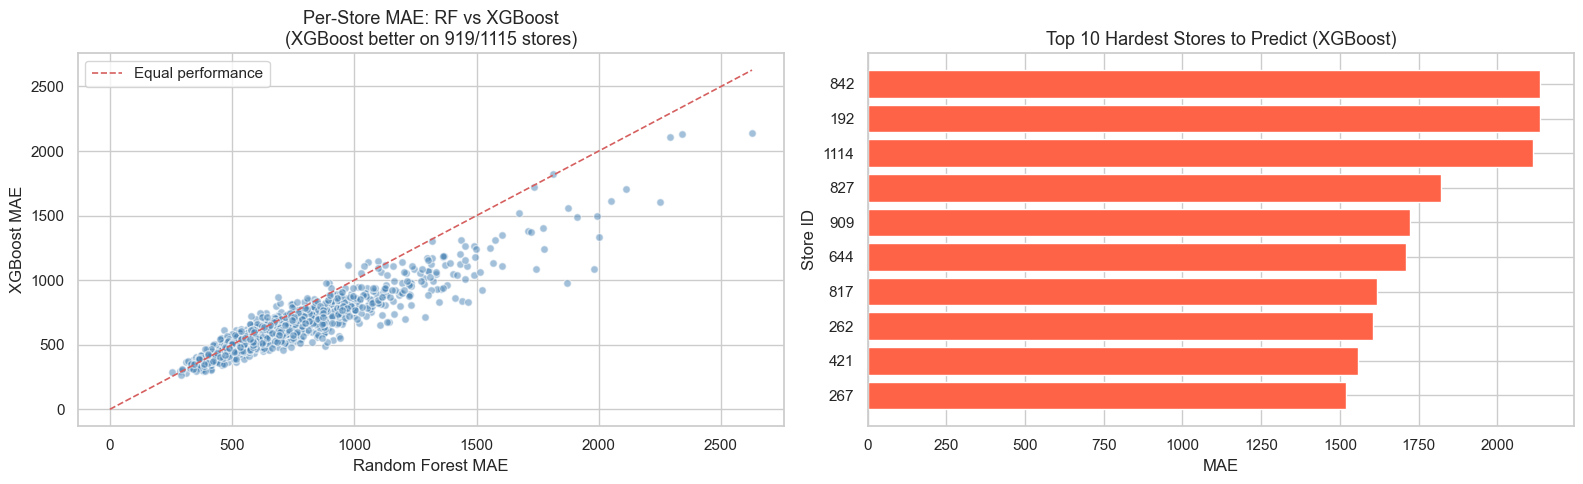

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scatter RF vs XGBoost MAE
axes[0].scatter(store_errors['RF_MAE'], store_errors['XGB_MAE'],
                alpha=0.5, s=30, color='steelblue', edgecolors='white')
max_val = max(store_errors['RF_MAE'].max(), store_errors['XGB_MAE'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=1.2, label='Equal performance')
xgb_better = (store_errors['XGB_MAE'] < store_errors['RF_MAE']).sum()
axes[0].set_title(f'Per-Store MAE: RF vs XGBoost\n(XGBoost better on {xgb_better}/{len(store_errors)} stores)')
axes[0].set_xlabel('Random Forest MAE')
axes[0].set_ylabel('XGBoost MAE')
axes[0].legend()

# Top 10 hardest stores
hard = store_errors.sort_values('XGB_MAE', ascending=False).head(10)
axes[1].barh(hard['Store'].astype(str), hard['XGB_MAE'], color='tomato')
axes[1].set_title('Top 10 Hardest Stores to Predict (XGBoost)')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('Store ID')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/figures/per_store_mae.png', dpi=150)
plt.show()

## 8. XGBoost Error by Day & Month

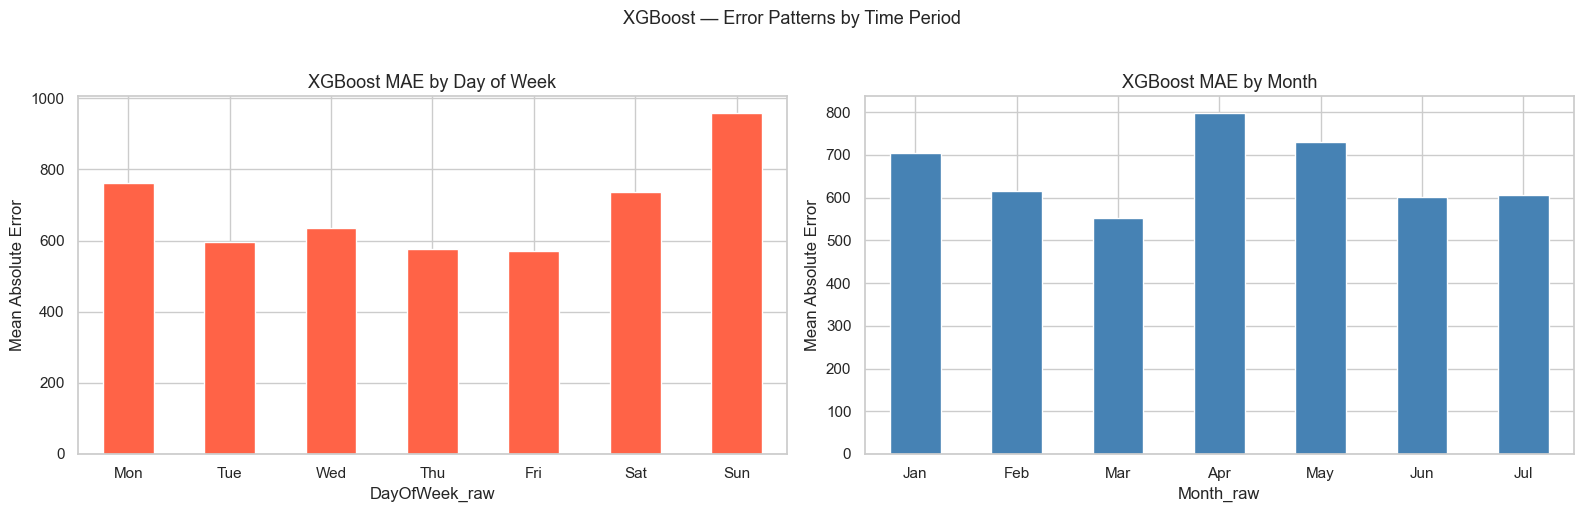

In [12]:
val_df['xgb_abs_err']   = np.abs(val_df['actual'] - val_df['xgb_pred'])
val_df['DayOfWeek_raw'] = val_df['Date'].dt.dayofweek
val_df['Month_raw']     = val_df['Date'].dt.month

dow_map   = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
             7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

dow_mae   = val_df.groupby('DayOfWeek_raw')['xgb_abs_err'].mean().rename(index=dow_map)
month_mae = val_df.groupby('Month_raw')['xgb_abs_err'].mean().rename(index=month_map)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

dow_mae.plot(kind='bar', ax=axes[0], color='tomato', edgecolor='white', rot=0)
axes[0].set_title('XGBoost MAE by Day of Week')
axes[0].set_ylabel('Mean Absolute Error')

month_mae.plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='white', rot=0)
axes[1].set_title('XGBoost MAE by Month')
axes[1].set_ylabel('Mean Absolute Error')

plt.suptitle('XGBoost — Error Patterns by Time Period', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/xgb_error_patterns.png', dpi=150)
plt.show()

## 9. Actual vs Predicted Scatter — XGBoost

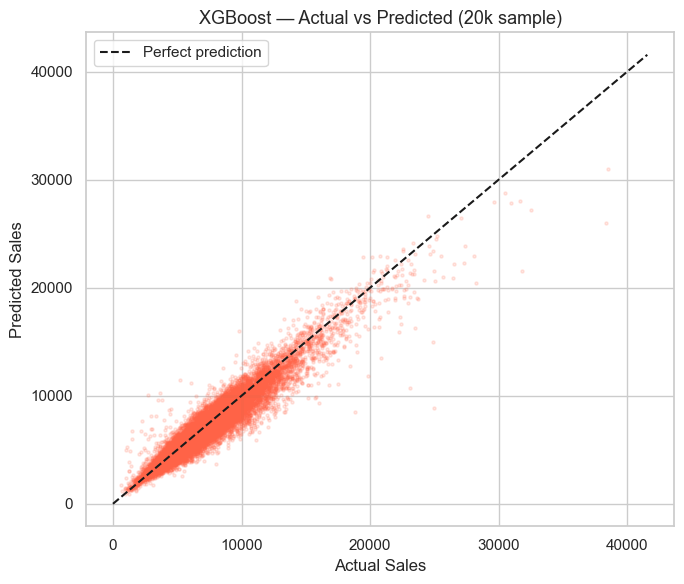

In [13]:
idx = np.random.choice(len(y_val_actual), size=20000, replace=False)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_val_actual[idx], xgb_pred[idx], alpha=0.15, s=5, color='tomato')
m = max(y_val_actual.max(), xgb_pred.max())
ax.plot([0, m], [0, m], 'k--', linewidth=1.5, label='Perfect prediction')
ax.set_xlabel('Actual Sales')
ax.set_ylabel('Predicted Sales')
ax.set_title('XGBoost — Actual vs Predicted (20k sample)')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/xgb_actual_vs_pred.png', dpi=150)
plt.show()

## 10. Save Results & Final Summary

In [14]:
results_df['Scope']    = ['All 1115 stores', 'All 1115 stores', f'Store {STORE_ID} only']
results_df['Features'] = ['94', '94', '1 (univariate)']

results_df.to_csv('../reports/final_comparison.csv', index=False)
print('Saved → reports/final_comparison.csv ✅')
print()
print(results_df.to_string(index=False))

Saved → reports/final_comparison.csv ✅

                  Model    MAE    RMSE  MAPE%           Scope       Features
          Random Forest 748.71 1115.93  10.91 All 1115 stores             94
                XGBoost 647.59  942.15   9.33 All 1115 stores             94
ARIMA(2,1,2)  [Store 1] 720.30  868.89  16.82    Store 1 only 1 (univariate)


## SALES FORECASTING PROJECT — FINAL SUMMARY

###  Dataset   : Rossmann (1115 stores, 2013-2015)                  
Train     : 675,958 rows  |  Val: 168,380 rows                 
Features  : 94 engineered features

### RESULTS                                                         
Random Forest    MAE: —       RMSE: —    (all stores)          
XGBoost [BEST]   MAE: 647.59  RMSE: 942.15  (all stores)       
ARIMA(2,1,2)     MAE: —       RMSE: —    (Store 1 only)

### KEY FINDINGS                                                    
* Lag & rolling features = strongest predictors                
* Promo boosts sales (EDA + ML confirmed)                      
* XGBoost outperforms RF on most stores                        
* ARIMA misses exogenous signals (Promo, holidays)             
* December & Monday show highest prediction error 